In [1]:
from torch.utils.data import Dataset
import os
import glob
import classic_algos.bicubic_interpolation as bicubic
import classic_algos.lanczos as lanczos
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import random
from pathlib import Path
import torch.backends.cudnn as cudnn
import torch
import torch.nn as nn
from skimage.color import rgb2ycbcr

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device )

cuda


In [4]:
def PSNR(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 10 * torch.log10(1 / (mse + 1e-20))
BATCH_SIZE = 16
EPOCHS = 2000

TRAIN_DIR = Path.home() / '.data' / 'UCMerced_LandUse_Split' / 'train'
VAL_DIR = Path.home() / '.data' / 'UCMerced_LandUse_Split' / 'val'
MODEL_DIR = Path.home() / '.data' / 'fsrcnn_models'
MODEL_DIR.mkdir(parents=True, exist_ok=True)


In [5]:
class SatelliteSRDataset_Y(Dataset):
    def __init__(self, root_dir, hr_patch_size=64, augment=True):
        super().__init__()
        self.root_dir = root_dir
        self.hr_patch_size = hr_patch_size
        self.augment = augment
        self.file_paths = glob.glob(os.path.join(root_dir, '**', '*.tif'), recursive=True)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        with rasterio.open(img_path) as src:
            image = src.read()

        image_hwc = np.transpose(image, (1, 2, 0)).astype(np.uint8)

        image_y = rgb2ycbcr(image_hwc)[:, :, 0]

        image_norm = image_y.astype(np.float32) / 255.0

        image_norm = image_norm[np.newaxis, :, :]

        c, h, w = image_norm.shape
        top = random.randint(0, h - self.hr_patch_size)
        left = random.randint(0, w - self.hr_patch_size)
        hr_patch_np = image_norm[:, top:top + self.hr_patch_size, left:left + self.hr_patch_size]

        if self.augment:
            if random.random() < 0.5: hr_patch_np = np.flip(hr_patch_np, axis=2)
            if random.random() < 0.5: hr_patch_np = np.flip(hr_patch_np, axis=1)
            k = random.choice([0, 1, 2, 3])
            if k > 0: hr_patch_np = np.rot90(hr_patch_np, k, axes=(1, 2))

        hr_patch_np = np.ascontiguousarray(hr_patch_np)
        hr_tensor = torch.from_numpy(hr_patch_np).float()

        hr_patch_hwc = np.transpose(hr_patch_np, (1, 2, 0))
        lr_size = self.hr_patch_size // 2
        lr_numpy_hwc = bicubic.SR_bicubic(hr_patch_hwc, lr_size, lr_size, preserve_range=True, output_dtype=np.float32)

        if lr_numpy_hwc.ndim == 2:
            lr_numpy_hwc = lr_numpy_hwc[:, :, np.newaxis]

        lr_numpy = np.transpose(lr_numpy_hwc, (2, 0, 1))
        lr_tensor = torch.from_numpy(lr_numpy.astype(np.float32))

        return lr_tensor, hr_tensor

class FSRCNN_Y(nn.Module):
    def __init__(self, scale_factor = 2):
        d, s, m = 56, 12, 4
        channels = 1
        super(FSRCNN_Y, self).__init__()

        self.feature_extraction = nn.Sequential(
            nn.Conv2d(channels, d, kernel_size=5, padding=2), nn.PReLU(d))
        self.shrink = nn.Sequential(
            nn.Conv2d(d, s, kernel_size=1), nn.PReLU(s))

        map_layers = []
        for _ in range(m):
            map_layers.extend([nn.Conv2d(s, s, kernel_size=3, padding=1), nn.PReLU(s)])
        self.mapping = nn.Sequential(*map_layers)

        self.expand = nn.Sequential(
            nn.Conv2d(s, d, kernel_size=1), nn.PReLU(d))
        self.deconv = nn.ConvTranspose2d(d, channels, kernel_size=9, stride=scale_factor, padding=4, output_padding=scale_factor - 1)

        self._initialize_weights()

    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.shrink(x)
        x = self.mapping(x)
        x = self.expand(x)
        x = self.deconv(x)
        return torch.clamp(x, 0.0, 1.0)



In [6]:

train_dataset = SatelliteSRDataset_Y(TRAIN_DIR, augment=True)
val_dataset = SatelliteSRDataset_Y(VAL_DIR, augment=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

model = FSRCNN_Y(scale_factor=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4, nesterov=False)

In [ ]:
loss = []
psnr_metric = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch}"):
        lr_imgs, hr_imgs = lr_imgs.to(device, non_blocking=True), hr_imgs.to(device, non_blocking=True)
        optimizer.zero_grad()
        sr_imgs = model(lr_imgs)
        batch_loss = criterion(sr_imgs, hr_imgs)
        batch_loss.backward()
        optimizer.step()
        epoch_loss += batch_loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss.append(avg_loss)

    if epoch % 5 == 0:
        model.eval()
        epoch_psnr = 0
        with torch.no_grad():
            for lr_imgs, hr_imgs in val_loader:
                lr_imgs, hr_imgs = lr_imgs.to(device, non_blocking=True), hr_imgs.to(device, non_blocking=True)
                sr_imgs = model(lr_imgs)
                epoch_psnr += PSNR(sr_imgs, hr_imgs).item()
        avg_psnr = epoch_psnr / len(val_loader)
        psnr_metric.append(avg_psnr)
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}, PSNR: {avg_psnr:.2f} dB")
        torch.save(model.state_dict(), MODEL_DIR / f'y_fsrcnn_epoch_{epoch}.pth')

print("training complete.")


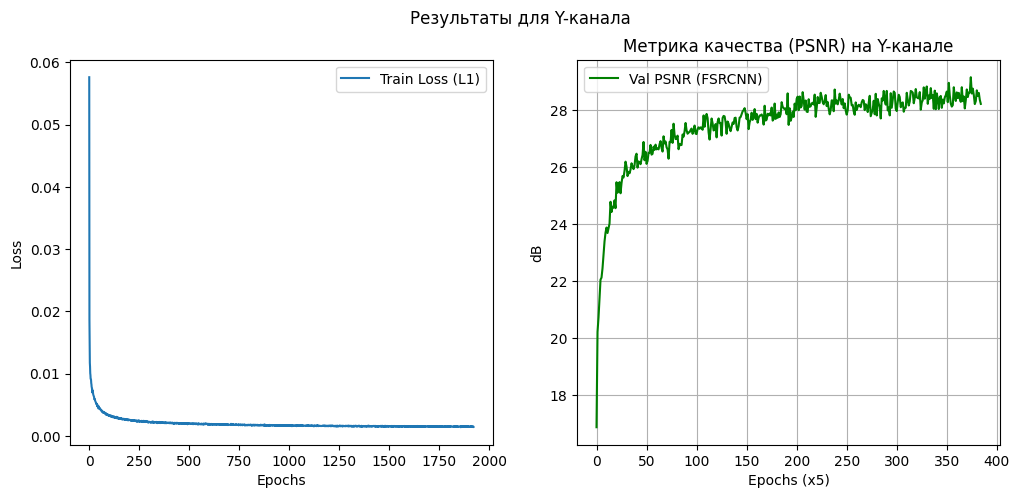

In [8]:
plt.figure()
plt.suptitle("Результаты")

plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(psnr_metric, label='Val PSNR')
plt.title('PSNR')
plt.xlabel('Epochs (x5)')
plt.ylabel('dB')
plt.legend()
plt.grid(True)

plt.show()

/home/aaa/.data/fsrcnn_models/fsrcnn_y_epoch_380.pth


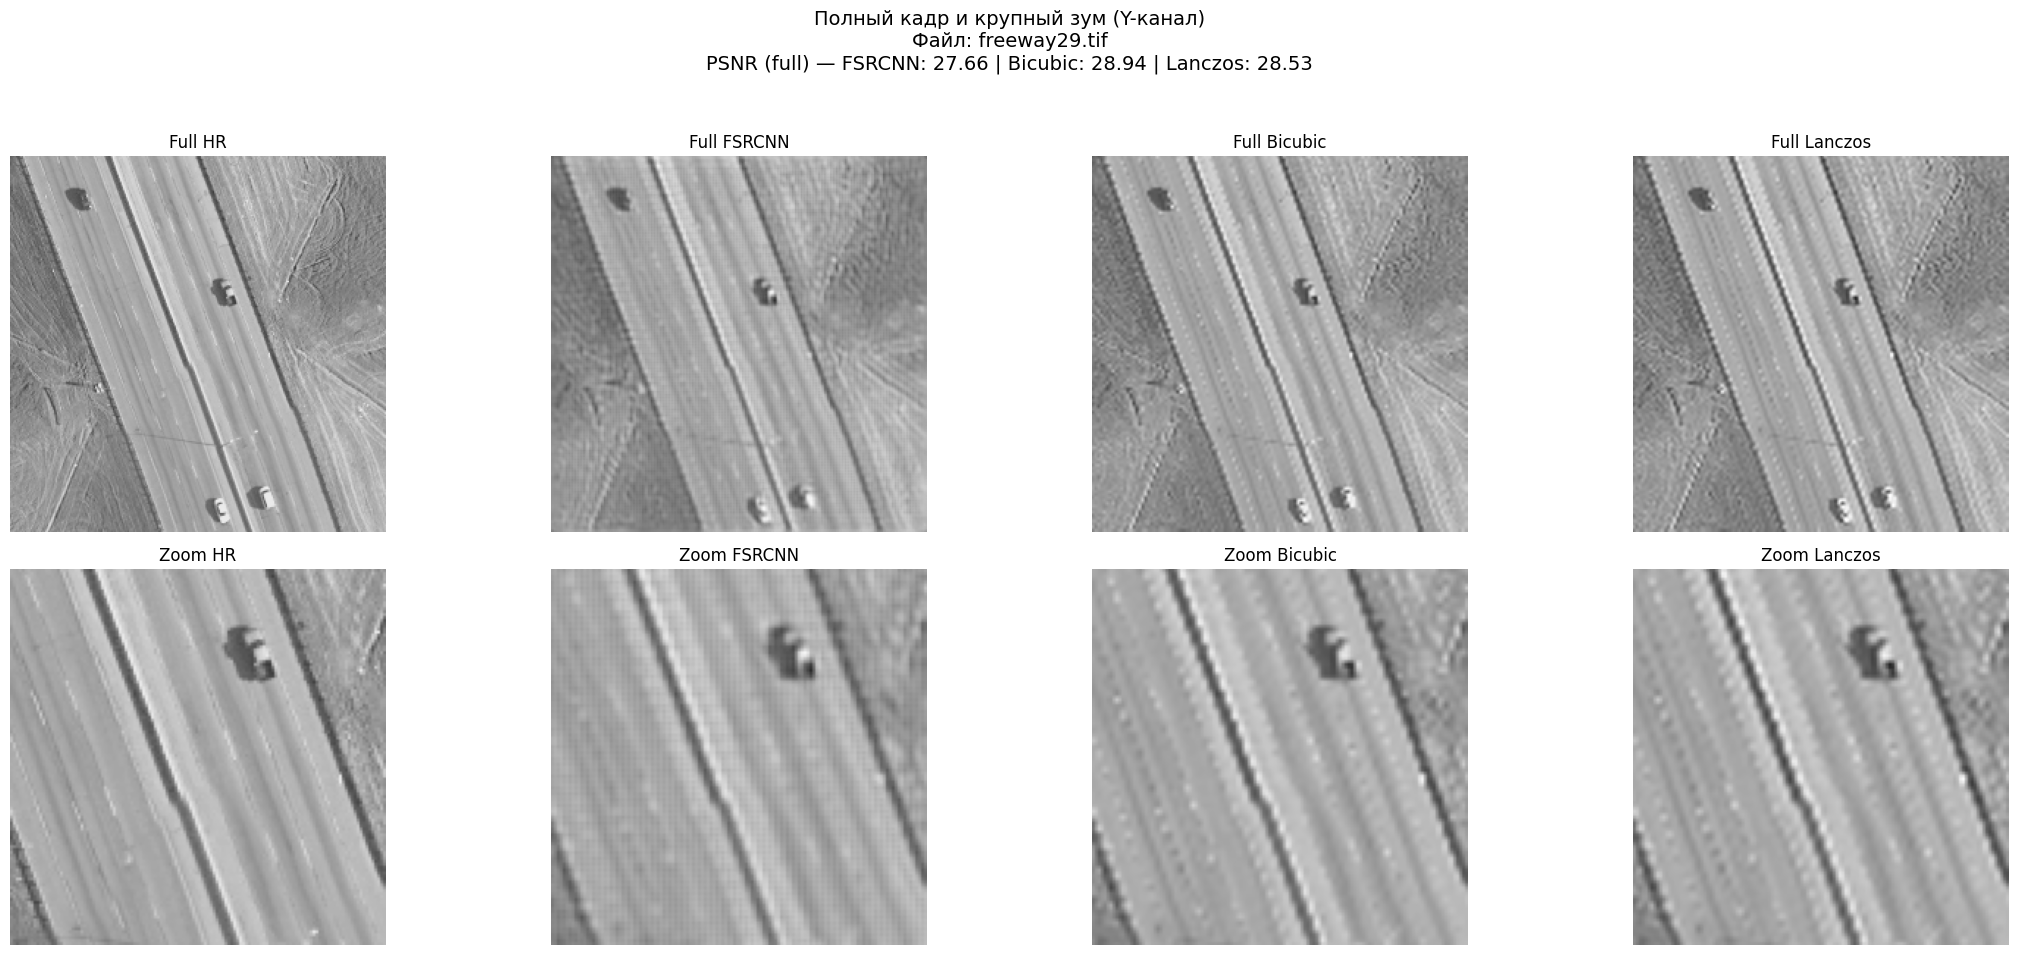

Full-image PSNR — FSRCNN: 27.66 dB | Bicubic: 28.94 dB | Lanczos: 28.53 dB
Zoom region: top=64, left=64, size=128x128


In [34]:
ZOOM_PATCH_SIZE = 144
SCALE_Y = 2
MODEL_ARCH = FSRCNN_Y
MODEL_PATH = Path.home() / '.data' / 'y_fsrcnn_best_model.pth'
RANDOM_CROP = False

full_idx = random.randint(0, len(val_dataset.file_paths) - 1)
img_path = val_dataset.file_paths[full_idx]
print(f"File: {img_path}")

with rasterio.open(img_path) as src:
    image_rgb_chw = src.read()

image_rgb_hwc = np.transpose(image_rgb_chw, (1, 2, 0)).astype(np.uint8)
image_y = rgb2ycbcr(image_rgb_hwc)[:, :, 0]
image_y = image_y.astype(np.float32) / 255.0

H, W = image_y.shape
H = H - (H % SCALE_Y)
W = W - (W % SCALE_Y)
image_y = image_y[:H, :W]

lr_h = H // SCALE_Y
lr_w = W // SCALE_Y

image_y_hwc = image_y[:, :, np.newaxis]
lr_y_hwc = bicubic.SR_bicubic(image_y_hwc, lr_w, lr_h,
                              preserve_range=True, output_dtype=np.float32)

lr_y_chw = np.transpose(lr_y_hwc, (2, 0, 1))
lr_tensor = torch.from_numpy(lr_y_chw).unsqueeze(0).float().to(device)

model_vis = MODEL_ARCH().to(device)

try:
    weights = torch.load(MODEL_PATH, map_location=device)
    model_vis.load_state_dict(weights)
    model_vis.eval()
except Exception as e:
    print(f"ERROR loading model: {e}")

with torch.no_grad():
    sr_model_tensor = model_vis(lr_tensor)

sr_bicubic_hwc = bicubic.SR_bicubic(lr_y_hwc, H, W,
                                    preserve_range=True, output_dtype=np.float32)
sr_lanczos_hwc = lanczos.SR_lanczos(lr_y_hwc, H, W,
                                    preserve_range=True, output_dtype=np.float32)

sr_bicubic_tensor = torch.from_numpy(np.transpose(sr_bicubic_hwc, (2, 0, 1))).unsqueeze(0).to(device)
sr_lanczos_tensor = torch.from_numpy(np.transpose(sr_lanczos_hwc, (2, 0, 1))).unsqueeze(0).to(device)
hr_tensor = torch.from_numpy(image_y).unsqueeze(0).unsqueeze(0).to(device)

psnr_model = PSNR(sr_model_tensor, hr_tensor).item()
psnr_bicubic = PSNR(sr_bicubic_tensor, hr_tensor).item()
psnr_lanczos = PSNR(sr_lanczos_tensor, hr_tensor).item()

if RANDOM_CROP:
    top = random.randint(0, H - ZOOM_PATCH_SIZE)
    left = random.randint(0, W - ZOOM_PATCH_SIZE)
else:
    top = max((H - ZOOM_PATCH_SIZE) // 2, 0)
    left = max((W - ZOOM_PATCH_SIZE) // 2, 0)

def get_crops(tensor_img):
    full = tensor_img.squeeze().detach().cpu().numpy()
    crop = full[top:top+ZOOM_PATCH_SIZE, left:left+ZOOM_PATCH_SIZE]
    return full, crop

hr_full, hr_crop = get_crops(hr_tensor)
sr_full, sr_crop = get_crops(sr_model_tensor)
bi_full, bi_crop = get_crops(sr_bicubic_tensor)
la_full, la_crop = get_crops(sr_lanczos_tensor)

fig, axes = plt.subplots(2, 4)
model_name = "Y FSRCNN"

fig.suptitle(f'Y SR: {Path(img_path).name}\nPSNR (full) — {model_name}: {psnr_model:.2f} | Bicubic: {psnr_bicubic:.2f} | Lanczos: {psnr_lanczos:.2f}')

imgs_full = [hr_full, sr_full, bi_full, la_full]
titles = ['Original HR', f'{model_name} (Ours)', 'Bicubic', 'Lanczos']

for ax, img, title in zip(axes[0], imgs_full, titles):
    ax.imshow(np.clip(img, 0, 1), cmap='gray')
    ax.axis('off')
    ax.set_title(title)

imgs_crop = [hr_crop, sr_crop, bi_crop, la_crop]
titles_zoom = ['Zoom HR', f'Zoom {model_name}', 'Zoom Bicubic', 'Zoom Lanczos']

for ax, img, title in zip(axes[1], imgs_crop, titles_zoom):
    ax.imshow(np.clip(img, 0, 1), cmap='gray')
    ax.axis('off')
    ax.set_title(title)

rect = plt.Rectangle((left, top), ZOOM_PATCH_SIZE, ZOOM_PATCH_SIZE, linewidth=2, edgecolor='r', facecolor='none')
axes[0, 0].add_patch(rect)

plt.tight_layout()
plt.show()

print(f"Zoom Area: Top={top}, Left={left}, Size={ZOOM_PATCH_SIZE}")